In [8]:
import pandas as pd
import xgboost
import numpy as np
import torch
from shap import DeepExplainer
import matplotlib.pyplot as plt

In [2]:
wine_df = pd.read_csv('winequality.csv')

In [3]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Data Exploration

#### Missing Values


In [7]:
n=0
for col in wine_df.columns:
    missing = wine_df[col].isnull().sum()
    
    if missing > 0:
        print(f' {col} is missing {missing} values')
        n=1
        
if n==0:
    print('No missing values!')

No missing values!


#### Distributions

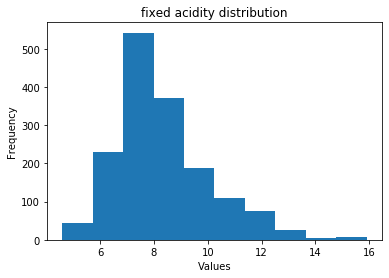

In [25]:
column = 0
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

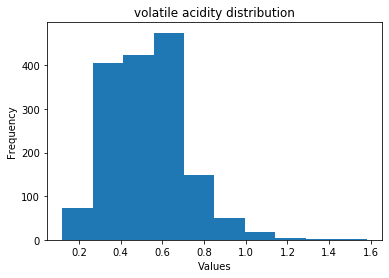

In [26]:
column = 1
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

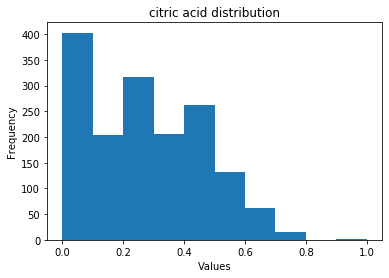

In [27]:
column = 2
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

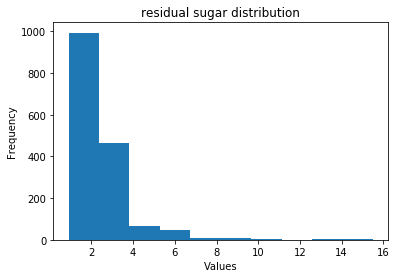

In [28]:
column = 3
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

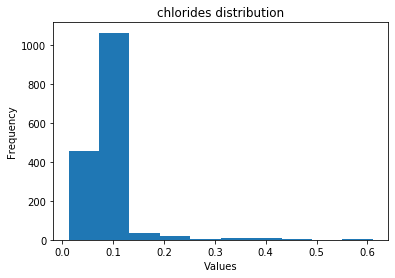

In [29]:
column = 4
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

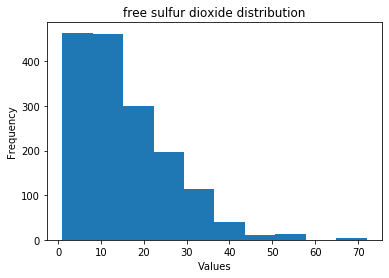

In [30]:
column = 5
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

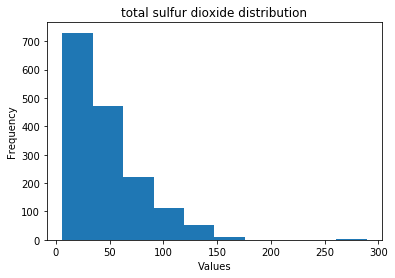

In [31]:
column = 6
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

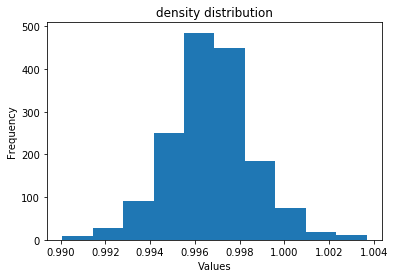

In [32]:
column = 7
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

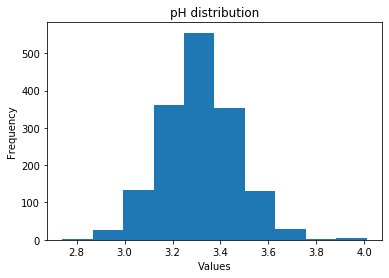

In [33]:
column = 8
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

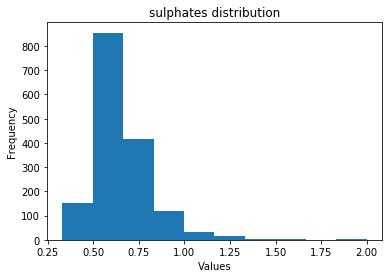

In [34]:
column = 9
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

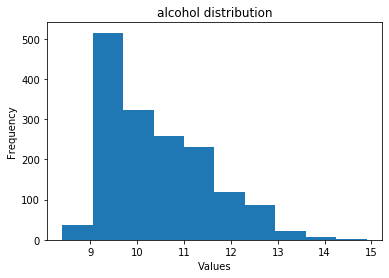

In [35]:
column = 10
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

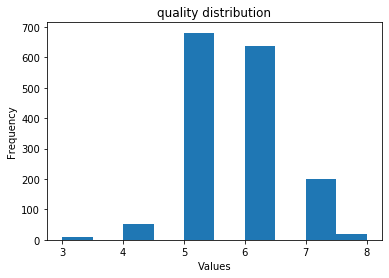

In [36]:
column = 11
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')